In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
print(cv2.__version__)

4.10.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam

In [6]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            image_path = f"{data_dir}/{directory}/{files}"
            image_list.append(convert_image_to_array(image_path))
            label_list.append(binary_labels[all_labels.index(directory)])
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    class_labels = classes
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    predictions = model.predict(image.reshape(1, 256, 256, 3))

    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    prediction_values = predictions[0]

    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()

In [7]:
#Loading the Data

In [8]:
dir_path = 'C:/Users/listra/PM/ProyekPM/Data baru'

all_labels = [i.split('/')[-1] for i in os.listdir(dir_path)]
binary_labels = [int(i) for i in range(len(all_labels))]

images, labels = load_dataset(dir_path)

In [12]:
all_labels

['Antraknosa', 'Cendawan Jelaga', 'Ulat daun']

In [13]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05, random_state=42  # 20% for testing
)

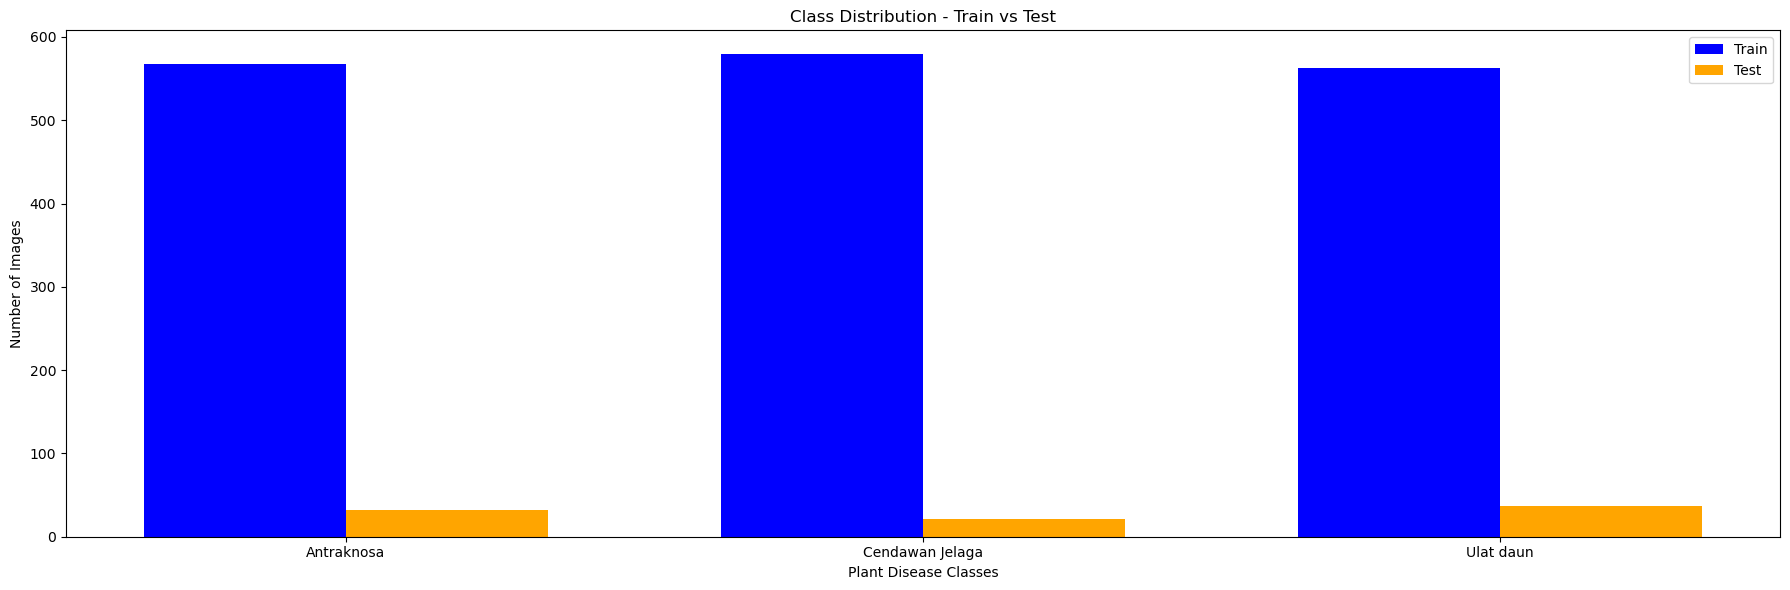

In [14]:
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=3)

classes = all_labels
train_colors = 'blue'
test_colors = 'orange'
bar_width = 0.35
index = np.arange(len(classes))
plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
#PreProcessing Data

In [16]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0
x_test = np.array(test_images, dtype=np.float16) / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1710, 256, 256, 3)
x_test shape: (90, 256, 256, 3)
y_train shape: (1710, 3)
y_test shape: (90, 3)


In [17]:
#Visualization

In [18]:
#Sample Train Images

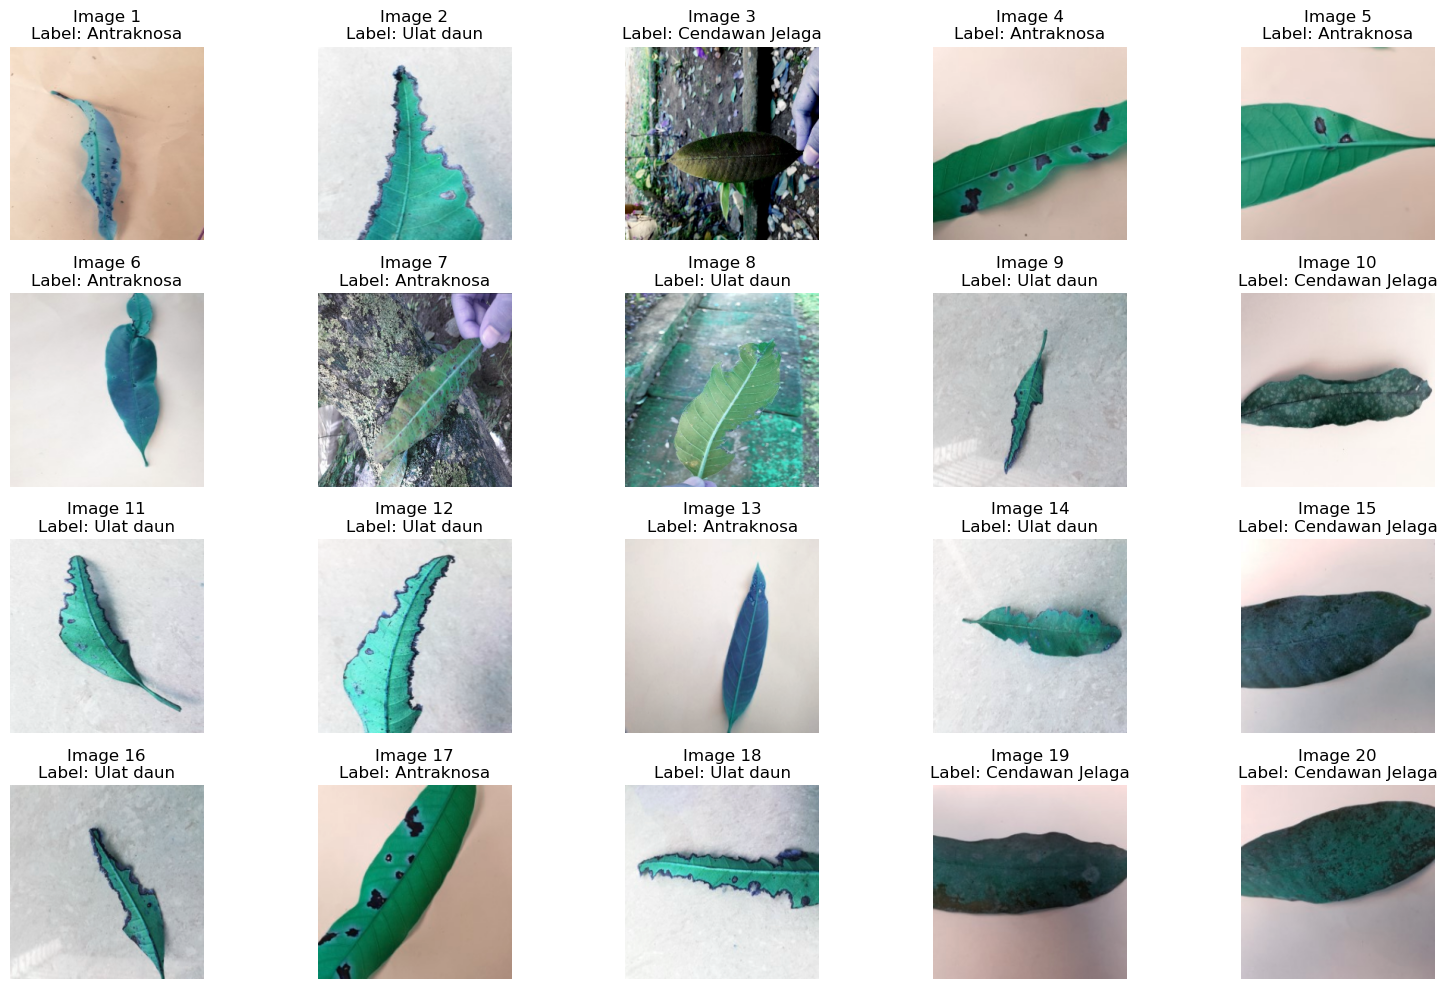

In [19]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
#Sample Test Images

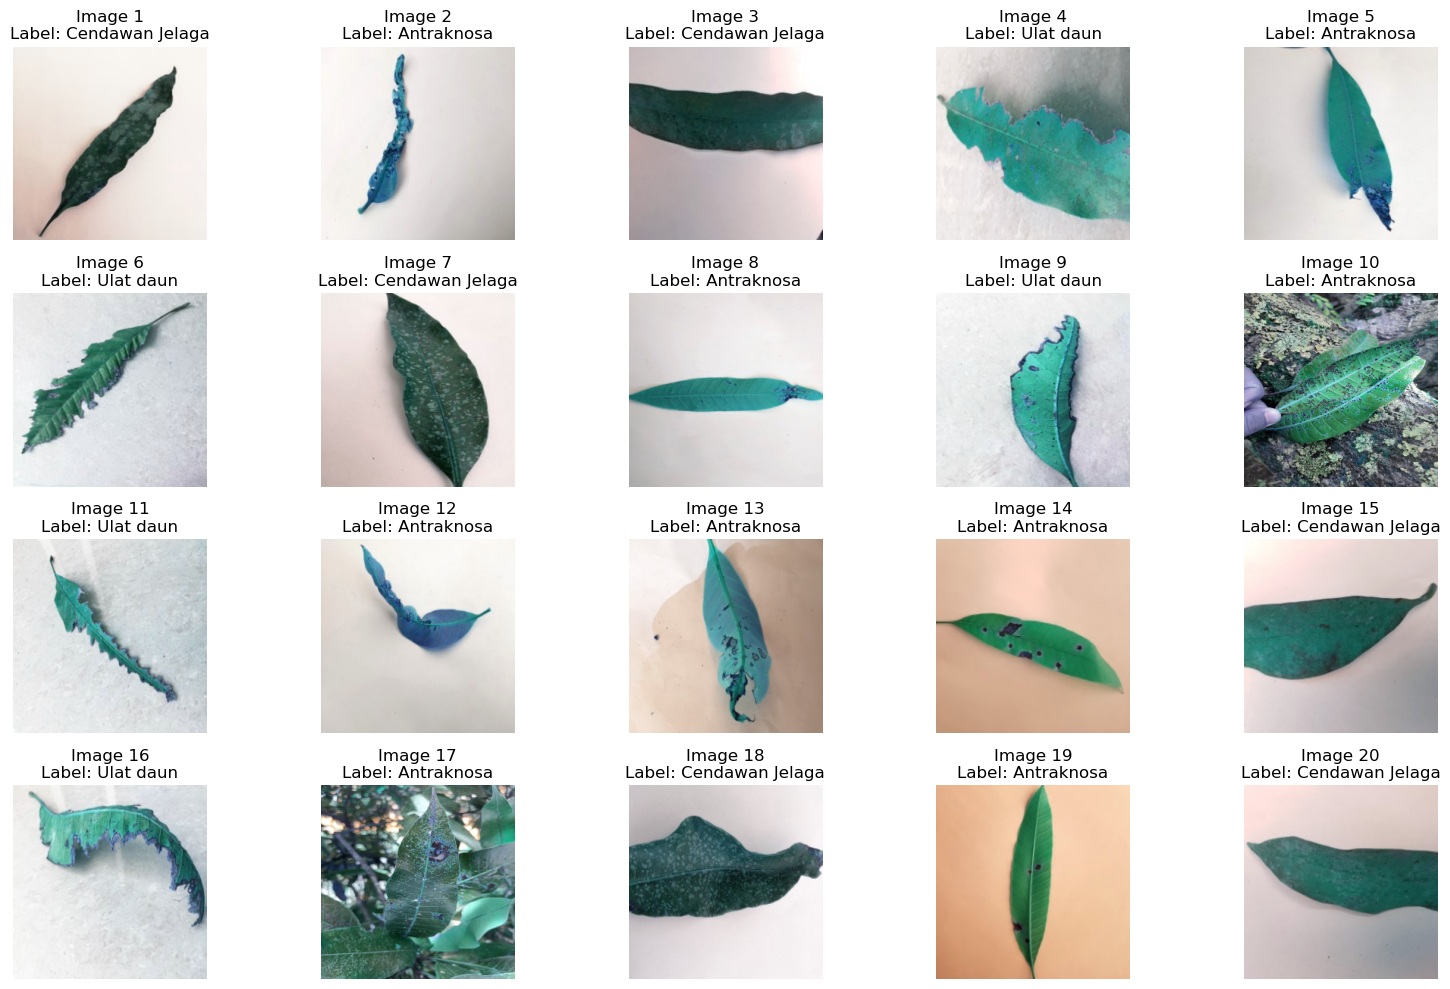

In [21]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Definition

In [23]:
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

# Function to build models using DenseNet121 or ResNet50
def build_model(model_name, input_shape=(256, 256, 3), num_classes=3):
    if model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Supported models are 'DenseNet121' and 'ResNet50'.")

    # Adding custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.6)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Creating the final model
    model = Model(inputs=base_model.input, outputs=output)

    return model


# Model Training

Training DenseNet121 model...
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.3680 - loss: 10.8831 - val_accuracy: 0.3222 - val_loss: 9.0567
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.5625 - loss: 8.1932 - val_accuracy: 0.3278 - val_loss: 7.5420
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.8299 - loss: 6.1885 - val_accuracy: 0.3333 - val_loss: 6.8236
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9588 - loss: 4.8324 - val_accuracy: 0.3056 - val_loss: 6.0206
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9712 - loss: 4.0464 - val_accuracy: 0.3528 - val_loss: 5.4443
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9646 - loss: 3.5350 - val_accuracy: 0.3333 - val_loss: 6.7474
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9578 - loss: 3.1524 - val_accuracy: 0.3306 - val_loss: 5.1692
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.9274 - loss: 2.

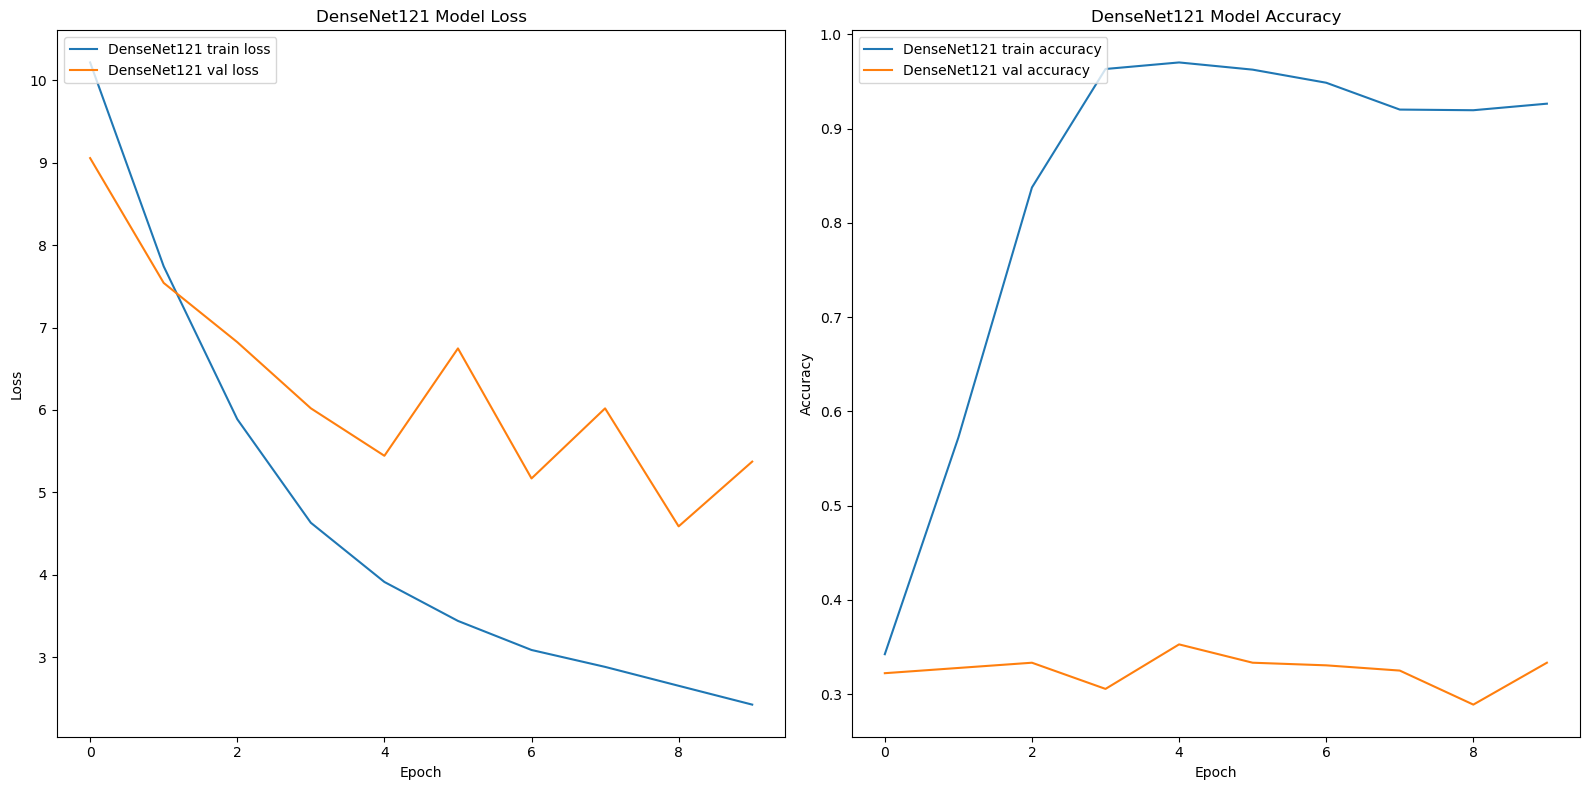

Training ResNet50 model...
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.3313 - loss: 14.4065 - val_accuracy: 0.3222 - val_loss: 28.9831
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.6443 - loss: 12.0368 - val_accuracy: 0.3222 - val_loss: 20.0501
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9438 - loss: 9.7971 - val_accuracy: 0.3222 - val_loss: 106.3323
Epoch 4/10
34/90 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - accuracy: 0.9442 - loss: 8.5385

In [ ]:
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Example dataset (replace with your actual dataset)
num_samples = 1800  # Number of samples
input_shape = (256, 256, 3)
num_classes = 3

# Generating dummy data (replace with real data)
x_data = np.random.rand(num_samples, *input_shape)  # Image data
y_data = np.random.randint(0, num_classes, size=(num_samples,))  # Labels

# One-hot encoding the labels
from tensorflow.keras.utils import to_categorical
y_data = to_categorical(y_data, num_classes=num_classes)

# Splitting data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Function to build models
def build_model(model_name, input_shape=(256, 256, 3), num_classes=3):
    if model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Supported models are 'DenseNet121' and 'ResNet50'.")

    # Adding custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.6)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Creating the final model
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Models to train
models = ['DenseNet121', 'ResNet50']
history_dict = {}
best_weights = {}

# Train and evaluate each model
for model_name in models:
    print(f"Training {model_name} model...")
    model = build_model(model_name, input_shape=input_shape, num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Store training history and model weights
    history_dict[model_name] = history.history
    best_weights[model_name] = model
    print(f"{model_name} model weights saved.")

    # Plot training history
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Loss plot
    ax[0].plot(history.history['loss'], label=f'{model_name} train loss')
    ax[0].plot(history.history['val_loss'], label=f'{model_name} val loss')
    ax[0].set_title(f'{model_name} Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')

    # Accuracy plot
    ax[1].plot(history.history['accuracy'], label=f'{model_name} train accuracy')
    ax[1].plot(history.history['val_accuracy'], label=f'{model_name} val accuracy')
    ax[1].set_title(f'{model_name} Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
